In [1]:
import numpy as np
from tensorflow.keras.layers import Dense,Flatten,LSTM
from keras.models import Sequential
import pandas as pd

In [52]:
def prepare_data(timeseries_data,n_timesteps):
    x_samples = []
    y_samples = []
    i = 0
    while(i < len(timeseries_data)-n_timesteps):
        y_index = i + n_timesteps
        y = timeseries_data[y_index]
        x = timeseries_data[i:y_index]
        x_samples.append(x)
        y_samples.append(y)
        i = i+1
    return np.array(x_samples),np.array(y_samples)     

In [53]:
#define input sequence
timeseries_data = [110,125,133,146,158,172,187,196,210]
#choose a number of time stamp
n_timesteps = 3
#arange the data to give into the model
x,y = prepare_data(timeseries_data,n_timesteps)

In [54]:
x,y

(array([[110, 125, 133],
        [125, 133, 146],
        [133, 146, 158],
        [146, 158, 172],
        [158, 172, 187],
        [172, 187, 196]]),
 array([146, 158, 172, 187, 196, 210]))

In [55]:
x.shape

(6, 3)

In [56]:
#reshape from [samples,timesteps] into [samples,timesteps,features]
n_features = 1 #only one input is given that is timeseries_data
x = x.reshape(x.shape[0],x.shape[1],n_features)

In [62]:
model = Sequential()
model.add(LSTM(50,activation='relu',return_sequences = True, input_shape=(n_timesteps,n_features)))
model.add(LSTM(50,activation='relu'))
model.add(Dense(1))

model.compile(optimizer = 'adam',loss = 'mse')

In [64]:
model.fit(x,y,epochs=300,verbose=0)

In [83]:
inputs = np.array([125,133,146]).reshape(1,3,1)
model.predict(inputs)

array([[158.07411]], dtype=float32)

# Stock market prediction and forecasting using stacked LSTM

In [174]:
import pandas_datareader as pdr
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math

In [157]:
df = pdr.get_data_tiingo('AAPL',api_key='38b36912abc8faac5536e5d0631cd9f6f0e31c6b')

In [158]:
df.to_csv('AAPL.csv')

In [159]:
df = pd.read_csv('AAPL.csv')

In [160]:
df1 = df['close']

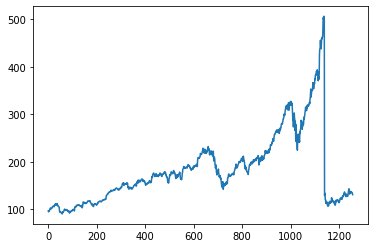

In [161]:
plt.plot(df1)

In [162]:
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [163]:
#split the dataset into train and test samples
training_size = int(len(df1)*0.65)
test_size = len(df1) - training_size
train_data,test_data = df1[0:training_size],df1[training_size:len(df1)]

In [164]:
print(len(train_data),len(test_data))

817 440


In [165]:
def create_dataset(dataset,time_step=1):
    x_samples,y_samples = [],[]
    i = 0
    while(i < len(dataset)-time_step):
        y_index = i + time_step
        y = dataset[y_index]
        x = dataset[i:y_index]
        x_samples.append(x)
        y_samples.append(y)
        i = i+1
    return np.array(x_samples),np.array(y_samples)     

In [166]:
time_step = 100
x_train,y_train = create_dataset(train_data,time_step)
x_test,y_test = create_dataset(test_data,time_step)

In [167]:
#reshape input to be [samples,time_step,features] which is required for LSTM
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],1)

In [168]:
#MODEL
model = Sequential()
model.add(LSTM(50,return_sequences = True, input_shape=(time_step,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))

model.compile(optimizer = 'adam',loss = 'mse')

In [169]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 100, 50)           10400     
_________________________________________________________________
lstm_14 (LSTM)               (None, 100, 50)           20200     
_________________________________________________________________
lstm_15 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [170]:
model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=30,batch_size=64,verbose=1)

Epoch 1/30
12/12 [==============================] - 10s 267ms/step - loss: 0.0155 - val_loss: 0.0519
Epoch 2/30
12/12 [==============================] - 2s 148ms/step - loss: 0.0024 - val_loss: 0.0230
Epoch 3/30
12/12 [==============================] - 2s 149ms/step - loss: 9.7329e-04 - val_loss: 0.0206
Epoch 4/30
12/12 [==============================] - 2s 148ms/step - loss: 4.2894e-04 - val_loss: 0.0202
Epoch 5/30
12/12 [==============================] - 2s 147ms/step - loss: 4.0840e-04 - val_loss: 0.0201
Epoch 6/30
12/12 [==============================] - 2s 150ms/step - loss: 3.8317e-04 - val_loss: 0.0198
Epoch 7/30
12/12 [==============================] - 2s 151ms/step - loss: 3.4847e-04 - val_loss: 0.0191
Epoch 8/30
12/12 [==============================] - 2s 151ms/step - loss: 3.2731e-04 - val_loss: 0.0186
Epoch 9/30
12/12 [==============================] - 2s 148ms/step - loss: 3.4384e-04 - val_loss: 0.0184
Epoch 10/30
12/12 [==============================] - 2s 150ms/step - lo

In [171]:
ytrain_predict = model.predict(x_train)
ytest_predict = model.predict(x_test)

In [172]:
y_train_predict = scaler.inverse_transform(ytrain_predict)
y_test_predict = scaler.inverse_transform(ytest_predict)

In [176]:
math.sqrt(mean_squared_error(y_train,y_train_predict))

164.36106738458625

In [177]:
math.sqrt(mean_squared_error(y_test,y_test_predict))

250.83978890377003

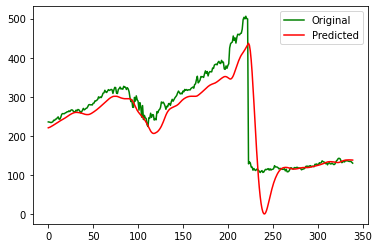

In [207]:
plt.plot(np.array(scaler.inverse_transform(y_test)),color='green',label='Original')
plt.plot(np.array(y_test_predict),color='red',label='Predicted')
plt.legend()

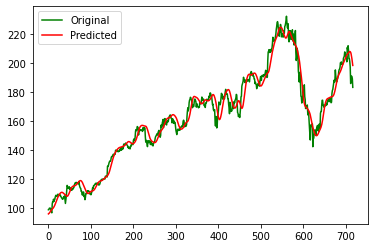

In [208]:
plt.plot(np.array(scaler.inverse_transform(y_train)),color='green',label='Original')
plt.plot(np.array(y_train_predict),color='red',label='Predicted')
plt.legend()

# Fake News Classifier

In [46]:
df = pd.read_csv('train-copy1.csv')

C:\Users\kousi\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (0,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,2

In [47]:
df = df[['text','label','title']]

In [48]:
df.label = df.label.map({'0':0,'1':1})

In [49]:
df.dropna(inplace=True)

In [50]:
df.isnull().sum()

text     0
label    0
title    0
dtype: int64

In [51]:
df.reset_index(inplace=True)

In [52]:
y = df.label
x = df.title

# text preprocessing using word embedding

In [53]:
from keras.layers import Embedding
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.preprocessing.text import one_hot
from keras.layers import LSTM
from keras.layers import Dense

In [54]:
voc_size = 5000

# Onehot Representation

In [55]:
import nltk 
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

In [56]:
messages = x.copy()

In [57]:
ps = PorterStemmer()
corpus = []
for i in range(0,len(messages)):
    review = re.sub('[^a-zA-Z]',' ',messages[i])
    review = review.lower().split()
    review = [ps.stem(word) for word in review if word not in set(stopwords.words('english'))]
    sentence = ' '.join(review)
    corpus.append(sentence)

In [58]:
corpus

['hous dem aid even see comey letter jason chaffetz tweet',
 'flynn hillari clinton big woman campu breitbart',
 'truth might get fire',
 'civilian kill singl us airstrik identifi',
 'iranian woman jail fiction unpublish stori woman stone death adulteri',
 'jacki mason hollywood would love trump bomb north korea lack tran bathroom exclus video breitbart',
 'life life luxuri elton john favorit shark pictur stare long transcontinent flight',
 'beno hamon win french socialist parti presidenti nomin new york time',
 'excerpt draft script donald trump q ampa black church pastor new york time',
 'back channel plan ukrain russia courtesi trump associ new york time',
 'obama organ action partner soro link indivis disrupt trump agenda',
 'bbc comedi sketch real housew isi caus outrag',
 'russian research discov secret nazi militari base treasur hunter arctic photo',
 'us offici see link trump russia',
 'major leagu soccer argentin find home success new york time',
 'well fargo chief abruptli st

In [60]:
onehot_rep = [one_hot(sentence,voc_size)for sentence in corpus]
onehot_rep

[[4007, 766, 1893, 763, 3764, 4295, 883, 781, 4610, 2792],
 [4723, 1735, 1829, 3372, 4626, 541, 1227],
 [638, 405, 7, 3848],
 [1763, 2404, 1885, 3223, 1335, 4069],
 [2574, 4626, 1610, 3936, 360, 204, 4626, 2643, 2160, 4156],
 [1921,
  4948,
  1758,
  3239,
  460,
  4123,
  4535,
  2439,
  2531,
  2854,
  1081,
  2928,
  4003,
  2257,
  1227],
 [1446, 1446, 3011, 4367, 3383, 4392, 4569, 610, 3158, 4977, 3022, 2685],
 [370, 1817, 521, 3687, 137, 670, 87, 2879, 287, 2312, 4424],
 [3403, 1739, 678, 2112, 4123, 620, 2129, 2396, 1998, 4415, 287, 2312, 4424],
 [196, 1577, 4601, 3386, 3828, 3727, 4123, 349, 287, 2312, 4424],
 [3507, 2126, 532, 4575, 1750, 3299, 2657, 1923, 4123, 4662],
 [4070, 3912, 4159, 2090, 1551, 3558, 2777, 3417],
 [1486, 3669, 460, 2764, 3027, 1009, 948, 842, 539, 32, 1637],
 [3223, 3398, 3764, 3299, 4123, 3828],
 [2881, 3083, 806, 2920, 4203, 3873, 4258, 287, 2312, 4424],
 [746, 2929, 1256, 214, 184, 287, 2312, 4424],
 [1047, 2563, 3049, 4745, 3484, 2475, 729, 4799, 218

# Embedding Representation

In [63]:
sent_length = 20
embedded_docs = pad_sequences(onehot_rep,padding='pre',maxlen=sent_length)
embedded_docs

array([[   0,    0,    0, ...,  781, 4610, 2792],
       [   0,    0,    0, ..., 4626,  541, 1227],
       [   0,    0,    0, ...,  405,    7, 3848],
       ...,
       [   0,    0,    0, ...,  287, 2312, 4424],
       [   0,    0,    0, ..., 3777, 2600, 1995],
       [   0,    0,    0, ..., 4676, 3453, 3618]])

In [65]:
#creating model
embedding_vector_features = 40
model = Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(LSTM(100))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [66]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 40)            200000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               56400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 256,501
Trainable params: 256,501
Non-trainable params: 0
_________________________________________________________________


In [67]:
x_final = np.array(embedded_docs)
y_final = np.array(y)

In [68]:
x_final.shape

(19118, 20)

In [69]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x_final,y_final,test_size = 0.2,random_state = 5)

In [70]:
model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=10,batch_size=1)

Epoch 1/10
15294/15294 [==============================] - 101s 6ms/step - loss: 0.2515 - accuracy: 0.9018 - val_loss: 0.1769 - val_accuracy: 0.9255
Epoch 2/10
15294/15294 [==============================] - 96s 6ms/step - loss: 0.1263 - accuracy: 0.9517 - val_loss: 0.2047 - val_accuracy: 0.9281
Epoch 3/10
15294/15294 [==============================] - 108s 7ms/step - loss: 0.0800 - accuracy: 0.9692 - val_loss: 0.1901 - val_accuracy: 0.9281
Epoch 4/10
 5225/15294 [=========>....................] - ETA: 1:09 - loss: 0.0407 - accuracy: 0.9838

KeyboardInterrupt: 

In [71]:
y_pred = model.predict_classes(x_test)

c:\users\kousi\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [72]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,y_pred)

array([[1788,  183],
       [ 126, 1727]], dtype=int64)

In [73]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.919194560669456